*ATTENZIONE: modello 2 dovrebbe essere rimosso in quanto divergente*

*conclusioni a partire dal modello 2 non devono essere considerate*

In [5]:
import pandas as pd
import pickle
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**fit**: modelli runnati su *df* filtrato per nvisite>25

**fitb**: modelli runnati su *df_balanced* con anche SESSO

In [9]:
with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/Report codes/Model_1/Model_1.pkl", "rb") as f:
    fit1 = pickle.load(f)
with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/Report codes/Model_2/Model_2.pkl", "rb") as f:
    fit2 = pickle.load(f)
with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/Report codes/Model_3/Model_3.pkl", "rb") as f:
    fit3 = pickle.load(f)
with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/Report codes/Model_4/Model_4.pkl", "rb") as f:
    fit4 = pickle.load(f)

with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/(2) Model selection beta/Model selection/SESSO/Model_1_SESSO.pkl", "rb") as f:
    fit1b = pickle.load(f)
with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/(2) Model selection beta/Model selection/SESSO/Model_2_SESSO.pkl", "rb") as f:
    fit2b = pickle.load(f)
with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/(2) Model selection beta/Model selection/SESSO/Model_3_SESSO.pkl", "rb") as f:
    fit3b = pickle.load(f)
with open("/content/drive/My Drive/Colab Notebooks/BS Project/Codes/(2) Model selection beta/Model selection/SESSO/Model_4_SESSO.pkl", "rb") as f:
    fit4b = pickle.load(f)

In [ ]:
def calc_hdi(sample, prob=0.95):
    sorted_sample = np.sort(sample)
    n = len(sorted_sample)
    interval_idx_inc = int(np.floor(prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = sorted_sample[interval_idx_inc:] - sorted_sample[:n_intervals]
    min_idx = np.argmin(interval_width)
    return sorted_sample[min_idx], sorted_sample[min_idx + interval_idx_inc]

def get_model_analysis(fit_obj, model_name):
    print(f"\n{'='*40}\nANALYSIS: {model_name}\n{'='*40}")

    available_vars = fit_obj.metadata.stan_vars.keys()
    beta_draws = fit_obj.stan_variable("beta")
    n_samples, n_p, n_k = beta_draws.shape
    current_covs = covariate_cols[:n_p]

    hard_shrinkage_list = []
    hpd_list = []

    for p in range(n_p):
        for k in range(n_k):
            sample_pk = beta_draws[:, p, k]

            low_ci, high_ci = np.percentile(sample_pk, [2.5, 97.5])
            if (low_ci > 0) or (high_ci < 0):
                hard_shrinkage_list.append(current_covs[p])

            hdi_low, hdi_high = calc_hdi(sample_pk, prob=0.95)
            if (hdi_low > 0) or (hdi_high < 0):
                hpd_list.append(current_covs[p])

    hard_shrinkage_list = sorted(list(set(hard_shrinkage_list)))
    hpd_list = sorted(list(set(hpd_list)))

    inclusion_prob_list = []
    if "tau" in available_vars and "lambda" in available_vars:
        tau_draws = fit_obj.stan_variable("tau")
        lambda_draws = fit_obj.stan_variable("lambda")
        kappa = 1.0 / (1.0 + (np.square(tau_draws)[:, np.newaxis] * np.square(lambda_draws)))
        mip = 1 - np.mean(kappa, axis=0)
        inclusion_prob_list = [current_covs[p] for p in range(n_p) if mip[p] > 0.5]

    print(f"1. Hard Shrinkage (95% CI != 0): {hard_shrinkage_list}")
    print(f"2. Highest Posterior Density (95% HDI != 0): {hpd_list}")
    print(f"3. Inclusion Probability (MIP > 0.5): {inclusion_prob_list}")

    beta_mean = np.mean(beta_draws, axis=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(beta_mean, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                xticklabels=target_list, yticklabels=current_covs)
    plt.title(f"Beta Posterior Means - {model_name}")
    plt.show()

    return hard_shrinkage_list, hpd_list, inclusion_prob_list

## **Covariates selection A**
for fit models

Using df.csv (22 covariates => no SESSO)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BS Project/Codes/Report codes/Data/df.csv")
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
ID_COL = "CAI"
covariate_cols = df.columns.drop(list(target_list) + [ID_COL]).tolist()
N = len(df)
K = len(target_list)
P = len(covariate_cols)
print(f"Dataset caricato: {N} osservazioni, {P} covariate, {K} target.")

Dataset caricato: 1025 osservazioni, 22 covariate, 5 target.



ANALYSIS: Model_1_Horseshoe
1. Hard Shrinkage (95% CI != 0): ['Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Monociti_perc', 'Polso']
2. Highest Posterior Density (95% HDI != 0): ['Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Polso']
3. Inclusion Probability (MIP > 0.5): []


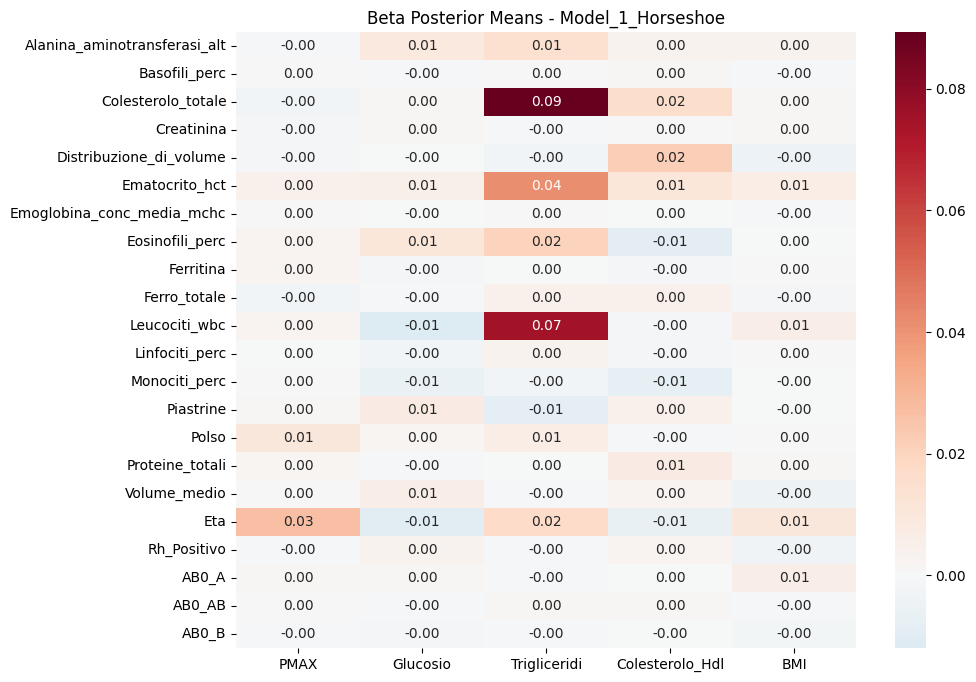


ANALYSIS: Model_2_Horseshoe_LKJ
1. Hard Shrinkage (95% CI != 0): ['AB0_A', 'Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Ferro_totale', 'Leucociti_wbc', 'Monociti_perc', 'Polso', 'Proteine_totali', 'Rh_Positivo']
2. Highest Posterior Density (95% HDI != 0): ['AB0_A', 'Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Ferro_totale', 'Leucociti_wbc', 'Monociti_perc', 'Polso', 'Rh_Positivo']
3. Inclusion Probability (MIP > 0.5): ['Rh_Positivo', 'AB0_A']


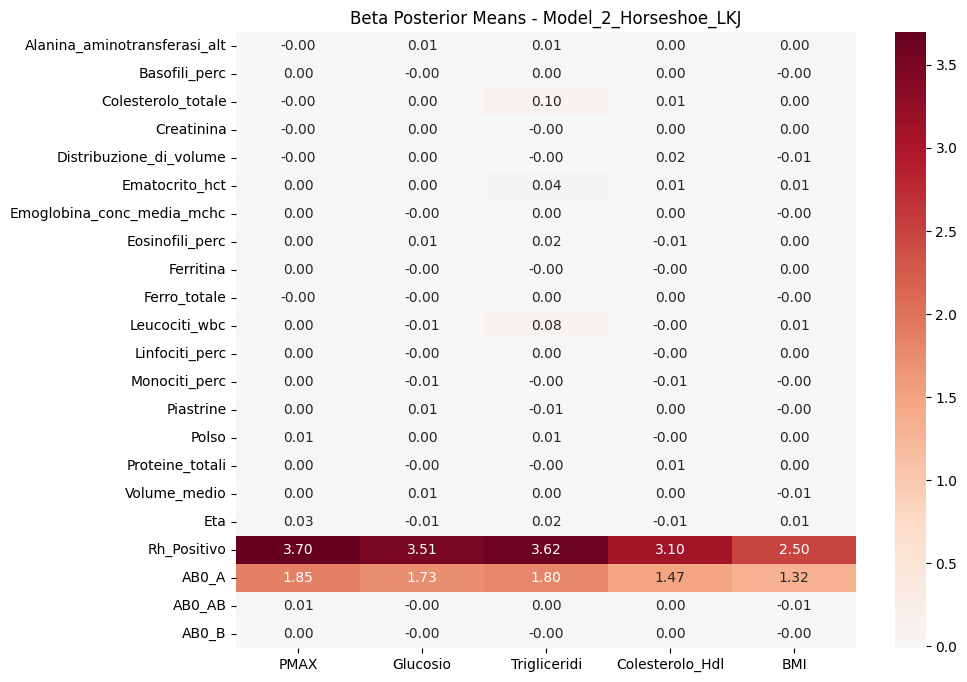


ANALYSIS: Model_3_Lasso
1. Hard Shrinkage (95% CI != 0): ['Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
2. Highest Posterior Density (95% HDI != 0): ['Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferro_totale', 'Leucociti_wbc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
3. Inclusion Probability (MIP > 0.5): []


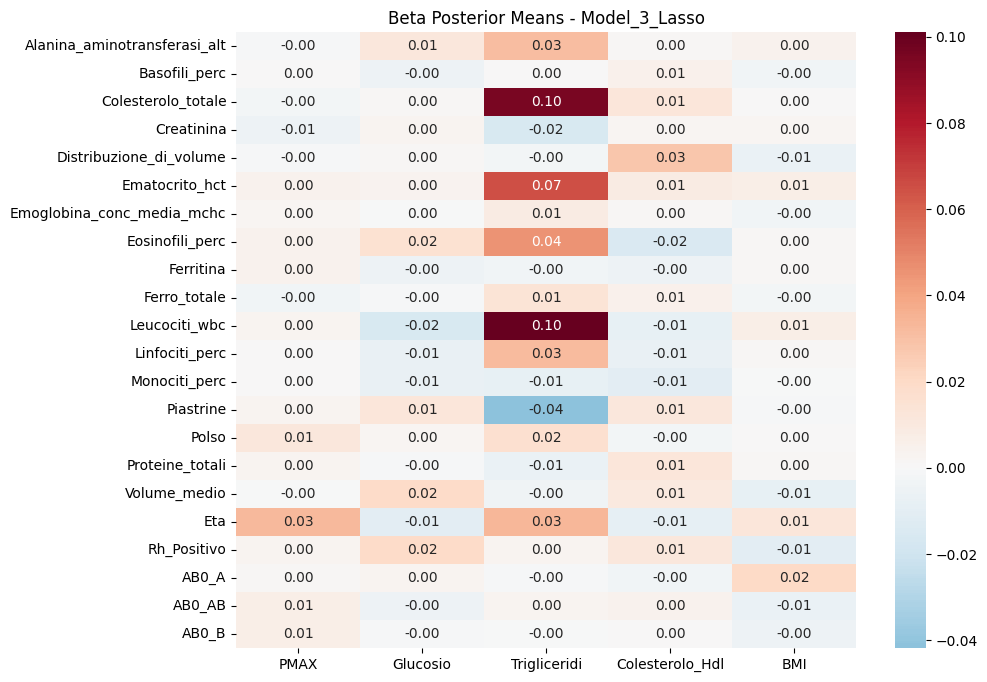


ANALYSIS: Model_4_Ridge
1. Hard Shrinkage (95% CI != 0): ['Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
2. Highest Posterior Density (95% HDI != 0): ['Alanina_aminotransferasi_alt', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
3. Inclusion Probability (MIP > 0.5): []


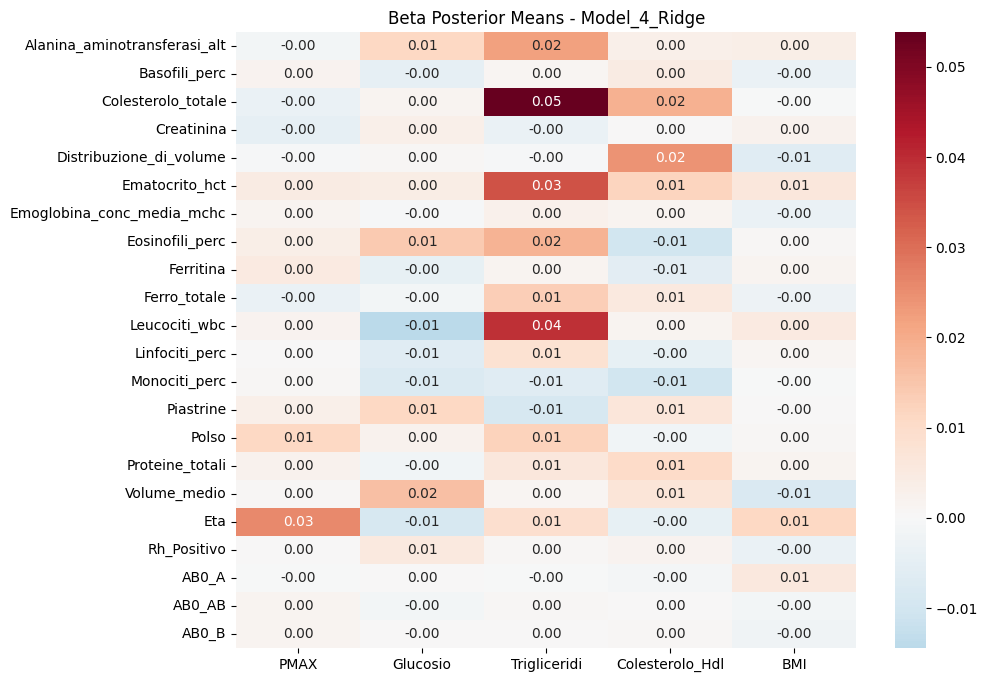

In [ ]:
res1 = get_model_analysis(fit1, "Model_1_Horseshoe")
res2 = get_model_analysis(fit2, "Model_2_Horseshoe_LKJ")
res3 = get_model_analysis(fit3, "Model_3_Lasso")
res4 = get_model_analysis(fit4, "Model_4_Ridge")

Just a plot, do not look at model 2 criteria (unreliable)

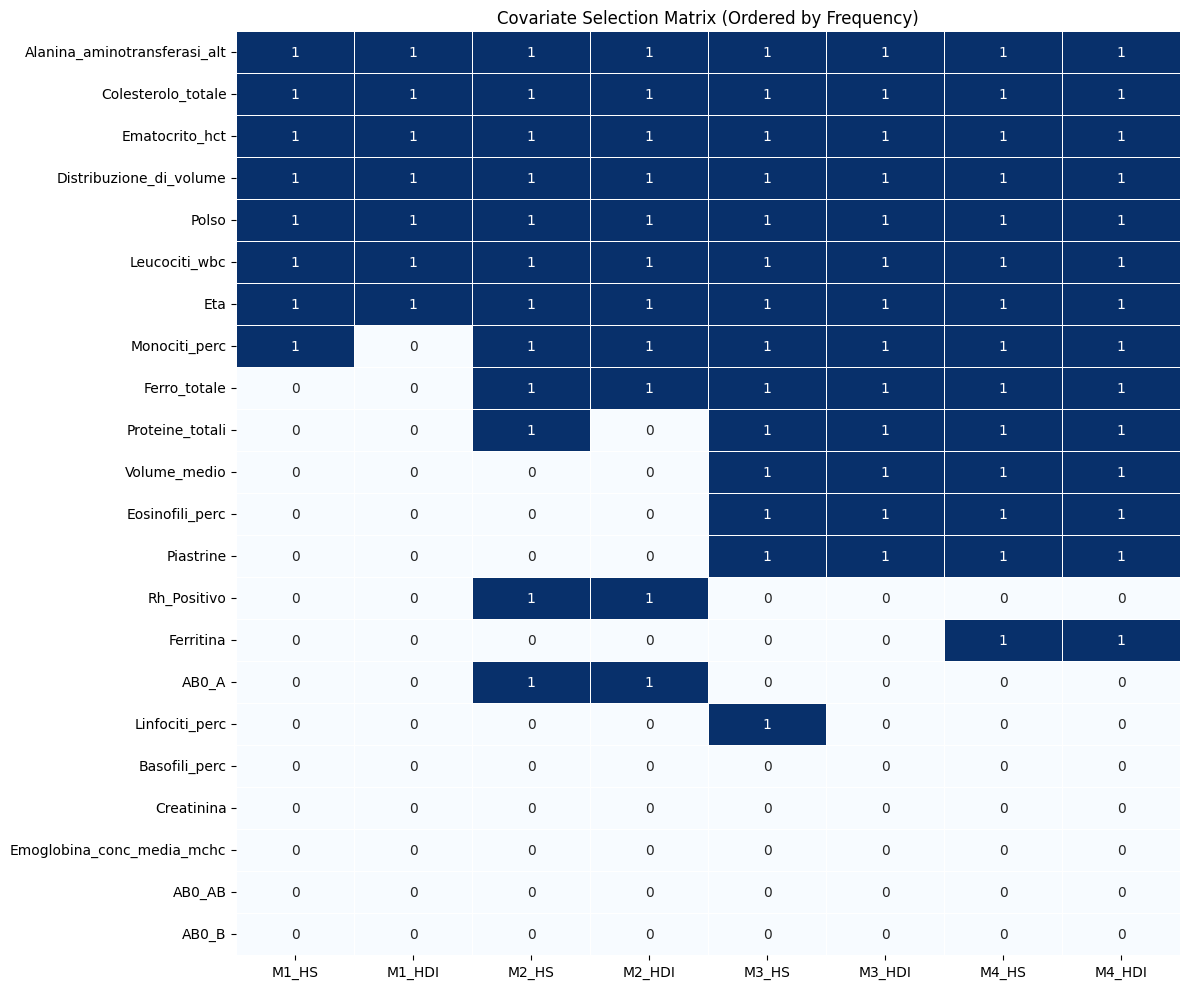

In [ ]:
cols = ['M1_HS', 'M1_HDI', 'M2_HS', 'M2_HDI', 'M3_HS', 'M3_HDI', 'M4_HS', 'M4_HDI']
lists = [res1[0], res1[1], res2[0], res2[1], res3[0], res3[1], res4[0], res4[1]]
summary_df = pd.DataFrame({c: [1 if x in l else 0 for x in covariate_cols] for c, l in zip(cols, lists)}, index=covariate_cols)
summary_df['Total'] = summary_df.sum(axis=1)
plot_df = summary_df.sort_values('Total', ascending=False).drop(columns=['Total'])

plt.figure(figsize=(12, 10))
sns.heatmap(plot_df, annot=True, cbar=False, cmap="Blues", linewidths=0.5)
plt.title("Covariate Selection Matrix (Ordered by Frequency)")
plt.tight_layout()
plt.show()

## **Covariates selection B**
for fitb models (based on df_balanced which includes SESSO)

Using df__mice_transformed_final.csv

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BS Project/Codes/Final datasets/df_mice_transformed_final.csv")
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
ID_COL = "CAI"
covariate_cols = df.columns.drop(list(target_list) + [ID_COL]).tolist()
N = len(df)
K = len(target_list)
P = len(covariate_cols)
print(f"Dataset caricato: {N} osservazioni, {P} covariate, {K} target.")

Dataset caricato: 35853 osservazioni, 23 covariate, 5 target.



ANALYSIS: Model_1_Horseshoe
1. Hard Shrinkage (95% CI != 0): ['Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Piastrine', 'Polso']
2. Highest Posterior Density (95% HDI != 0): ['Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Polso']
3. Inclusion Probability (MIP > 0.5): []


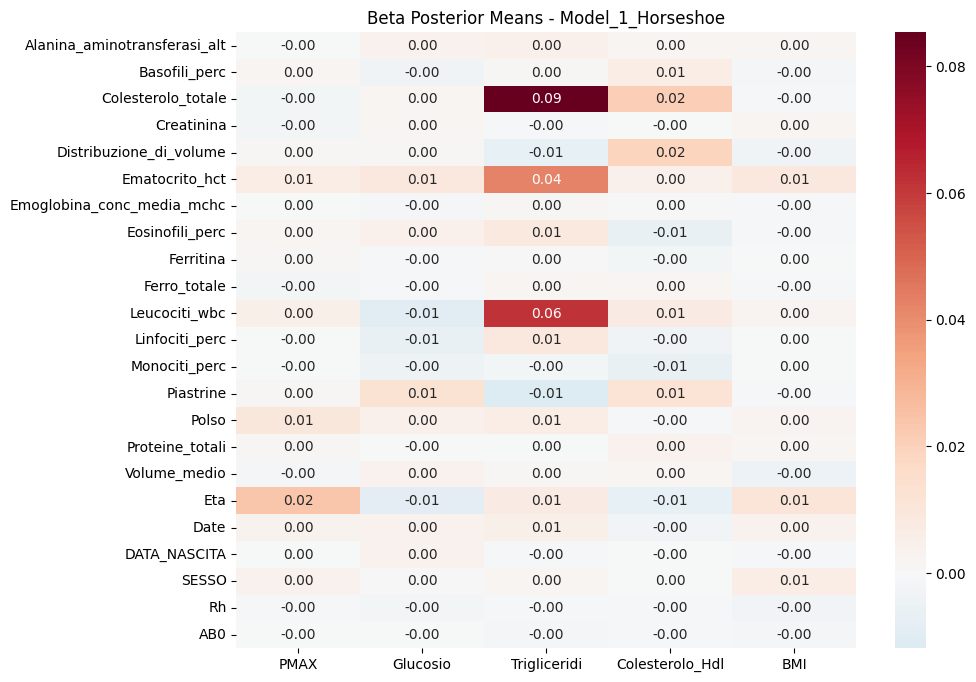


ANALYSIS: Model_2_Horseshoe_LKJ
1. Hard Shrinkage (95% CI != 0): ['Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Polso']
2. Highest Posterior Density (95% HDI != 0): ['Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Polso']
3. Inclusion Probability (MIP > 0.5): ['DATA_NASCITA']


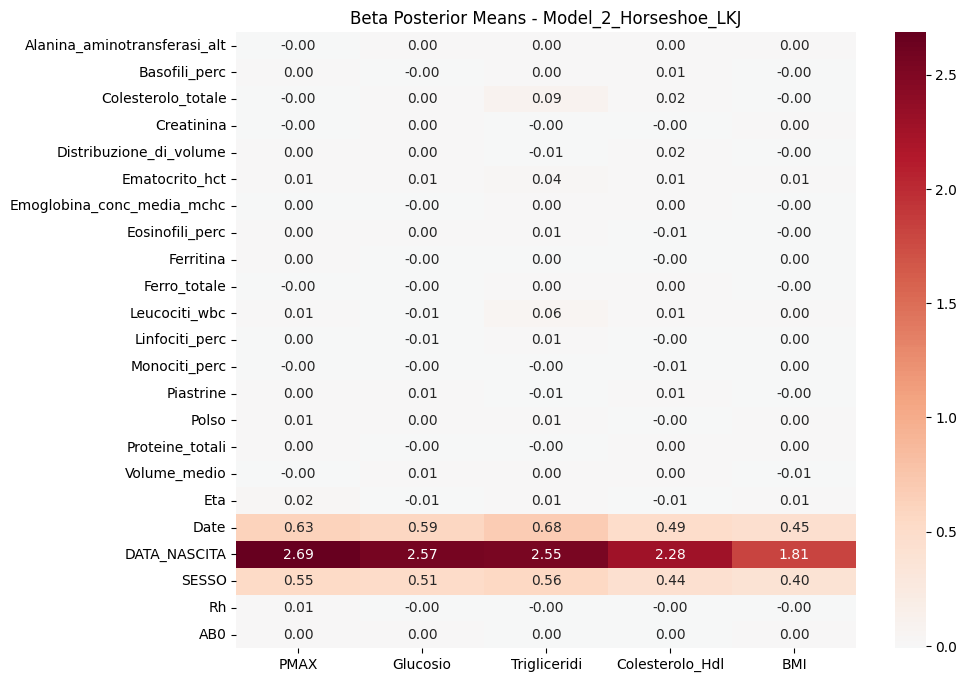


ANALYSIS: Model_3_Lasso
1. Hard Shrinkage (95% CI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
2. Highest Posterior Density (95% HDI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
3. Inclusion Probability (MIP > 0.5): []


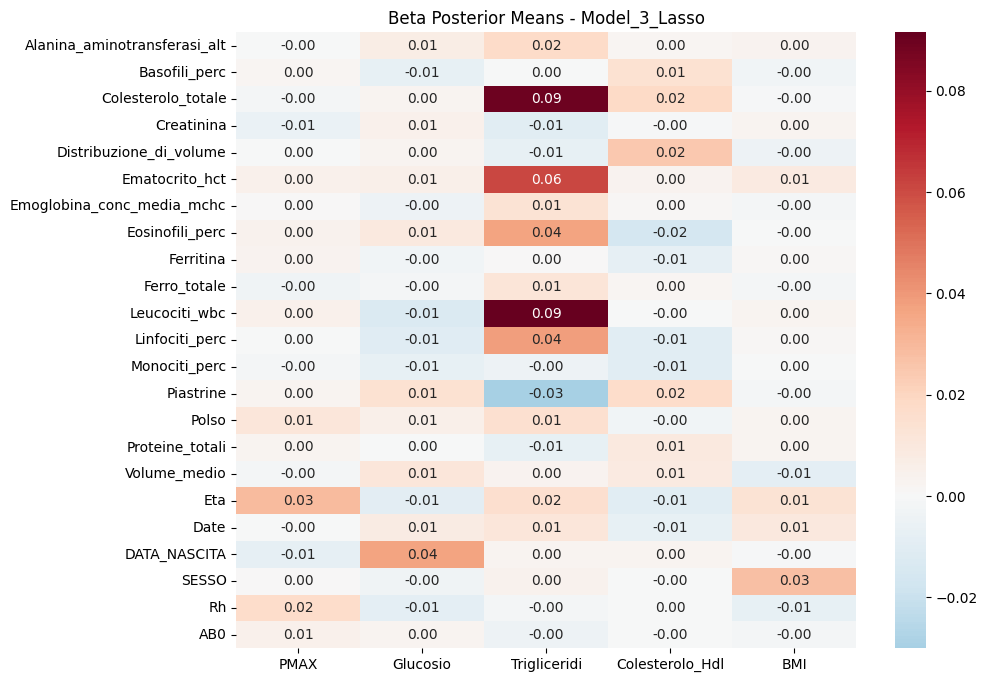


ANALYSIS: Model_4_Ridge
1. Hard Shrinkage (95% CI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
2. Highest Posterior Density (95% HDI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
3. Inclusion Probability (MIP > 0.5): []


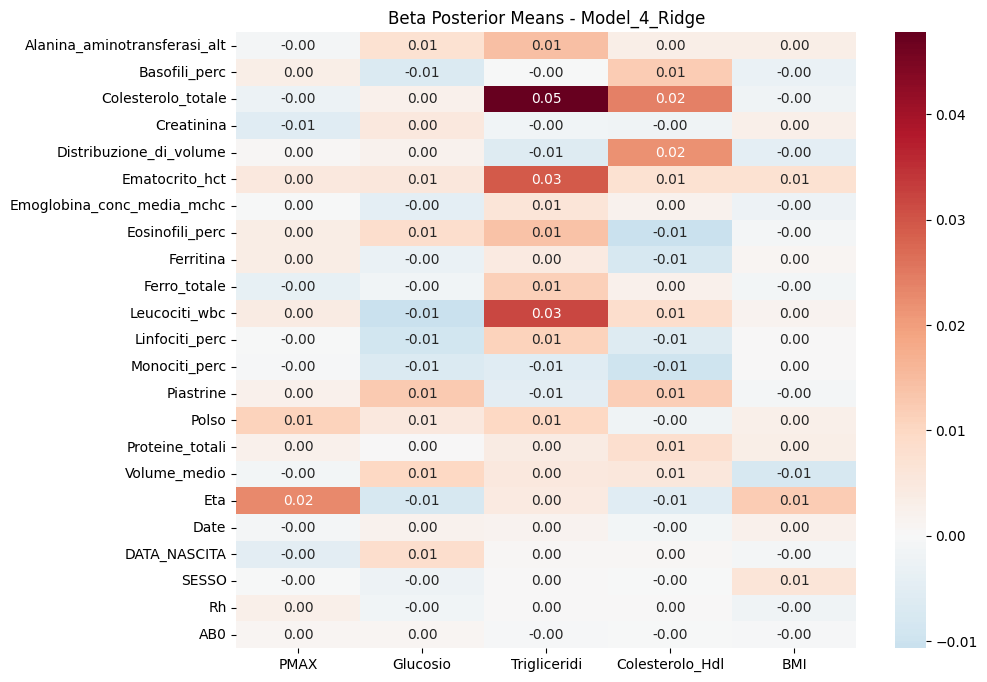

In [ ]:
res1b = get_model_analysis(fit1b, "Model_1_Horseshoe")
res2b = get_model_analysis(fit2b, "Model_2_Horseshoe_LKJ")
res3b = get_model_analysis(fit3b, "Model_3_Lasso")
res4b = get_model_analysis(fit4b, "Model_4_Ridge")

A plot to visualize (do not consider model 2)

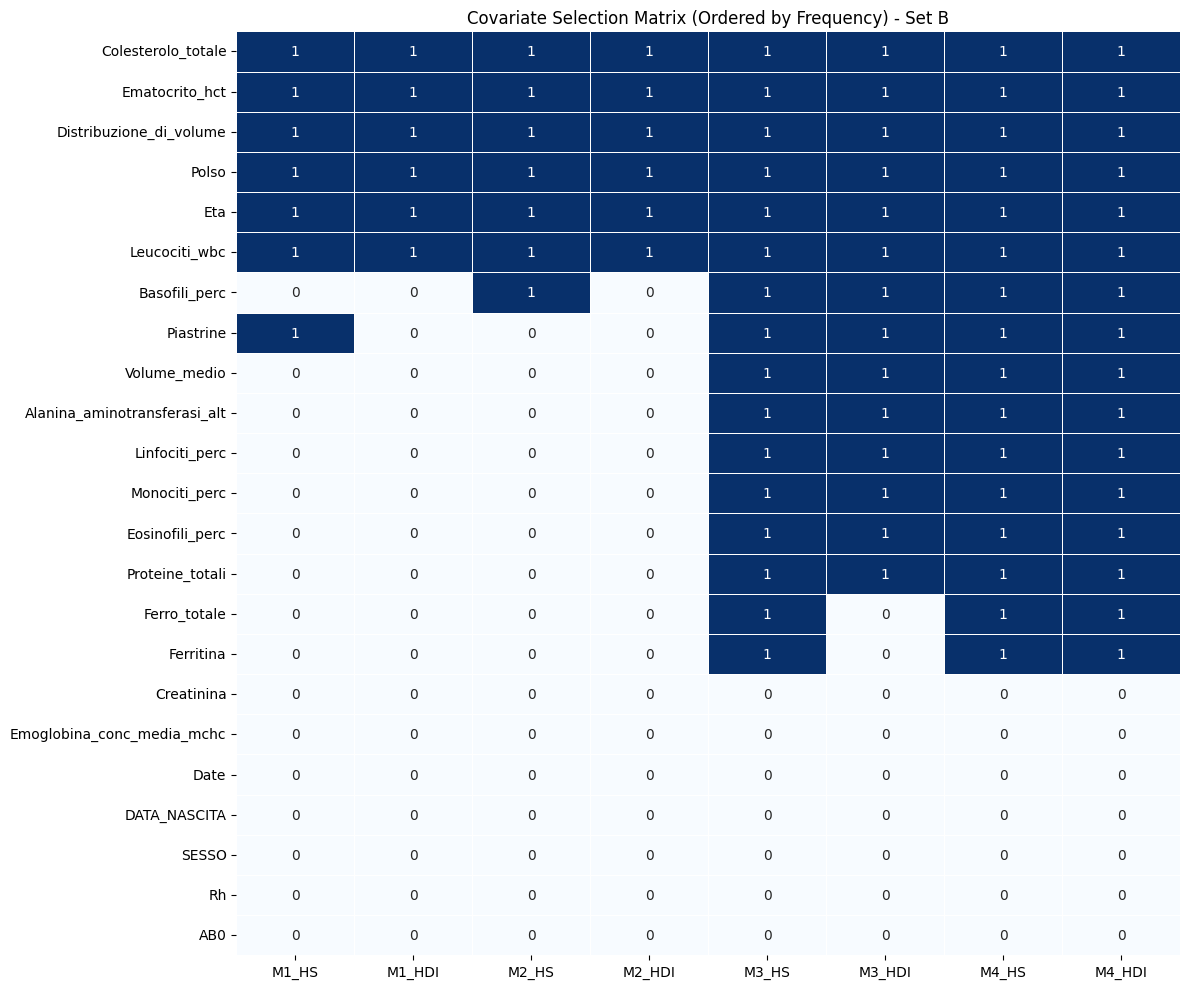

In [ ]:
cols = ['M1_HS', 'M1_HDI', 'M2_HS', 'M2_HDI', 'M3_HS', 'M3_HDI', 'M4_HS', 'M4_HDI']
lists = [res1b[0], res1b[1], res2b[0], res2b[1], res3b[0], res3b[1], res4b[0], res4b[1]]
summary_df = pd.DataFrame({c: [1 if x in l else 0 for x in covariate_cols] for c, l in zip(cols, lists)}, index=covariate_cols)
summary_df['Total'] = summary_df.sum(axis=1)
plot_df = summary_df.sort_values('Total', ascending=False).drop(columns=['Total'])
plt.figure(figsize=(12, 10))
sns.heatmap(plot_df, annot=True, cbar=False, cmap="Blues", linewidths=0.5)
plt.title("Covariate Selection Matrix (Ordered by Frequency) - Set B")
plt.tight_layout()
plt.show()

## **Covariate selection C**
Strong approach (at least for 3 targets the covariate is significant) for fitb models (based on df_balanced which includes SESSO)

In [21]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BS Project/Codes/Final datasets/df_mice_transformed_final.csv")
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
ID_COL = "CAI"
covariate_cols = df.columns.drop(list(target_list) + [ID_COL]).tolist()
N = len(df)
K = len(target_list)
P = len(covariate_cols)
print(f"Dataset caricato: {N} osservazioni, {P} covariate, {K} target.")

Dataset caricato: 35853 osservazioni, 23 covariate, 5 target.


In [25]:
def calc_hdi(sample, prob=0.95):
    sorted_sample = np.sort(sample)
    n = len(sorted_sample)
    interval_idx_inc = int(np.floor(prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = sorted_sample[interval_idx_inc:] - sorted_sample[:n_intervals]
    min_idx = np.argmin(interval_width)
    return sorted_sample[min_idx], sorted_sample[min_idx + interval_idx_inc]


def get_model_analysis(fit_obj, model_name, min_targets=3):
    print(f"\n{'='*40}\nANALYSIS: {model_name}\n{'='*40}")

    available_vars = fit_obj.metadata.stan_vars.keys()
    beta_draws = fit_obj.stan_variable("beta")
    n_samples, n_p, n_k = beta_draws.shape
    current_covs = covariate_cols[:n_p]

    hard_shrinkage_list = []
    hpd_list = []

    for p in range(n_p):
        hard_count = 0
        hpd_count = 0

        for k in range(n_k):
            sample_pk = beta_draws[:, p, k]

            low_ci, high_ci = np.percentile(sample_pk, [2.5, 97.5])
            if (low_ci > 0) or (high_ci < 0):
                hard_count += 1

            hdi_low, hdi_high = calc_hdi(sample_pk, prob=0.95)
            if (hdi_low > 0) or (hdi_high < 0):
                hpd_count += 1

        if hard_count >= min_targets:
            hard_shrinkage_list.append(current_covs[p])
        if hpd_count >= min_targets:
            hpd_list.append(current_covs[p])

    inclusion_prob_list = []
    if "tau" in available_vars and "lambda" in available_vars:
        tau_draws = fit_obj.stan_variable("tau")
        lambda_draws = fit_obj.stan_variable("lambda")
        kappa = 1.0 / (1.0 + (np.square(tau_draws)[:, np.newaxis] * np.square(lambda_draws)))
        mip = 1 - np.mean(kappa, axis=0)
        inclusion_prob_list = [current_covs[p] for p in range(n_p) if mip[p] > 0.5]

    print(f"1. Hard Shrinkage (95% CI != 0 in at least {min_targets} targets): {hard_shrinkage_list}")
    print(f"2. Highest Posterior Density (95% HDI != 0 in at least {min_targets} targets): {hpd_list}")
    print(f"3. Inclusion Probability (MIP > 0.5): {inclusion_prob_list}")

    beta_mean = np.mean(beta_draws, axis=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        beta_mean,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0,
        xticklabels=target_list,
        yticklabels=current_covs
    )
    plt.title(f"Beta Posterior Means - {model_name}")
    plt.show()

    return hard_shrinkage_list, hpd_list, inclusion_prob_list


ANALYSIS: Model_1_Horseshoe
1. Hard Shrinkage (95% CI != 0): ['Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Piastrine', 'Polso']
2. Highest Posterior Density (95% HDI != 0): ['Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Polso']
3. Inclusion Probability (MIP > 0.5): []


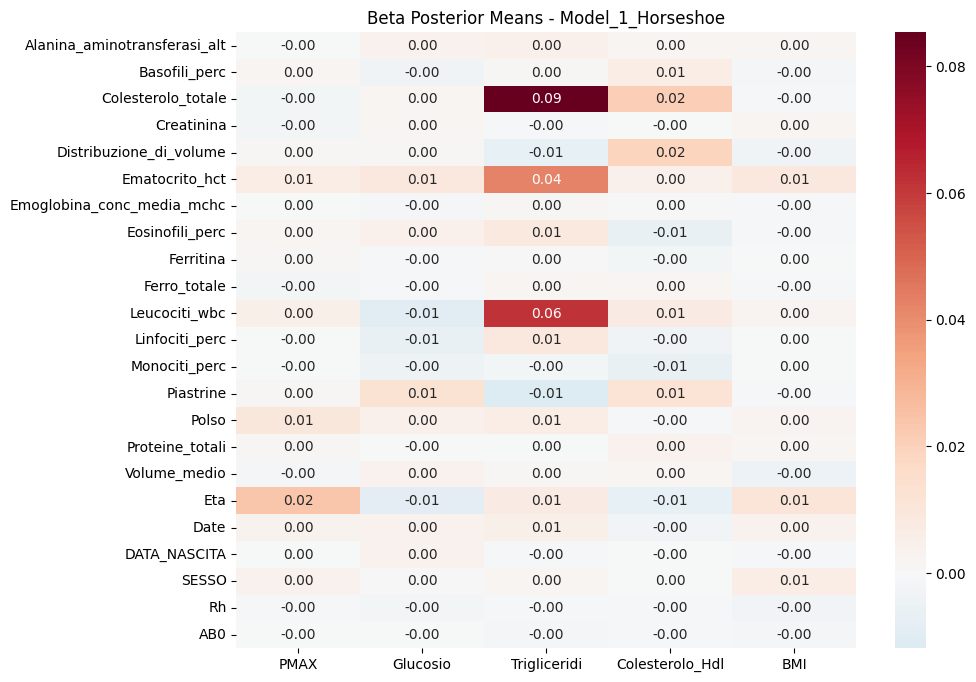


ANALYSIS: Model_2_Horseshoe_LKJ
1. Hard Shrinkage (95% CI != 0): ['Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Polso']
2. Highest Posterior Density (95% HDI != 0): ['Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eta', 'Leucociti_wbc', 'Polso']
3. Inclusion Probability (MIP > 0.5): ['DATA_NASCITA']


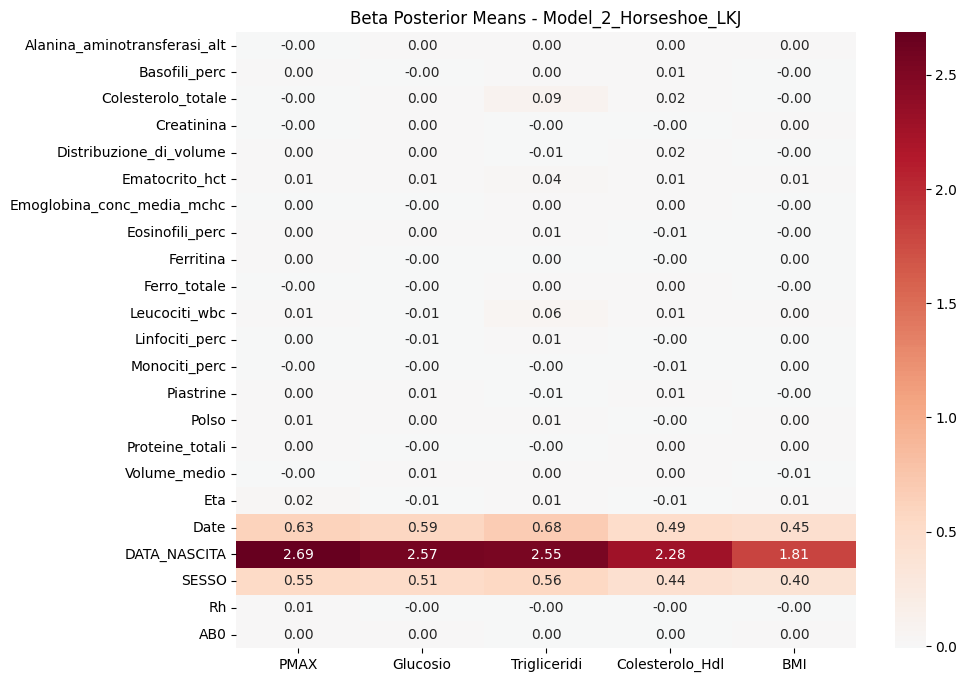


ANALYSIS: Model_3_Lasso
1. Hard Shrinkage (95% CI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
2. Highest Posterior Density (95% HDI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
3. Inclusion Probability (MIP > 0.5): []


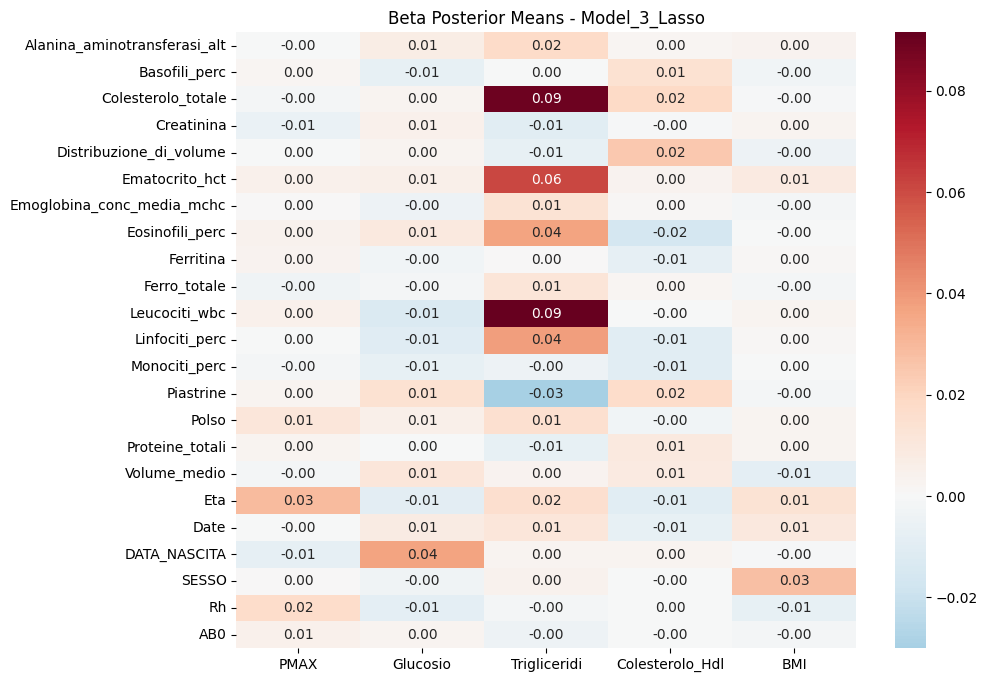


ANALYSIS: Model_4_Ridge
1. Hard Shrinkage (95% CI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
2. Highest Posterior Density (95% HDI != 0): ['Alanina_aminotransferasi_alt', 'Basofili_perc', 'Colesterolo_totale', 'Distribuzione_di_volume', 'Ematocrito_hct', 'Eosinofili_perc', 'Eta', 'Ferritina', 'Ferro_totale', 'Leucociti_wbc', 'Linfociti_perc', 'Monociti_perc', 'Piastrine', 'Polso', 'Proteine_totali', 'Volume_medio']
3. Inclusion Probability (MIP > 0.5): []


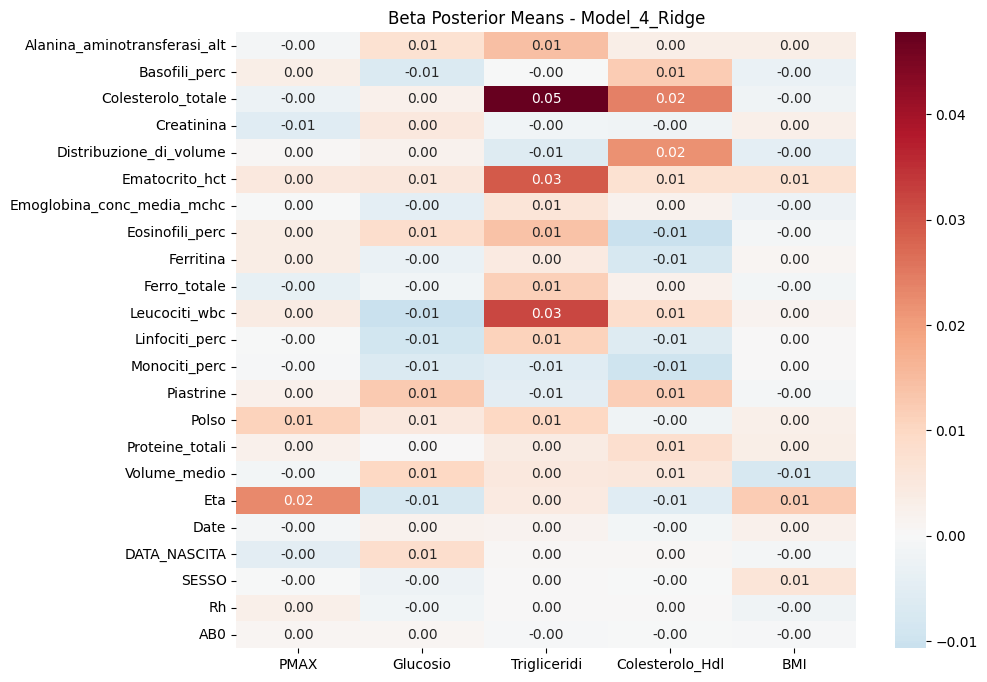

In [26]:
res1b = get_model_analysis(fit1b, "Model_1_Horseshoe")
res2b = get_model_analysis(fit2b, "Model_2_Horseshoe_LKJ")
res3b = get_model_analysis(fit3b, "Model_3_Lasso")
res4b = get_model_analysis(fit4b, "Model_4_Ridge")